Read files

In [699]:
import numpy as np
import random

def read_vrp_file(filepath: str):
    data = {
        "name": None,
        "dimension": None,
        "capacity": None,
        "customers": {},   # now contains x,y,demand
        "depot": None,
        "distance_matrix": None
    }

    coordinates = {}
    demands = {}

    section = None
    with open(filepath, "r") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("EOF"):
                continue

            # Metadata
            if line.startswith("NAME"):
                data["name"] = line.split(":")[1].strip()
            elif line.startswith("DIMENSION"):
                data["dimension"] = int(line.split(":")[1].strip())
            elif line.startswith("CAPACITY"):
                data["capacity"] = int(line.split(":")[1].strip())
            elif line.startswith("EDGE_WEIGHT_TYPE"):
                data["edge_weight_type"] = line.split(":")[1].strip()

            # Sections
            elif line.startswith("NODE_COORD_SECTION"):
                section = "coords"
                continue
            elif line.startswith("DEMAND_SECTION"):
                section = "demand"
                continue
            elif line.startswith("DEPOT_SECTION"):
                section = "depot"
                continue

            # Parse sections
            elif section == "coords":
                parts = line.split()
                node, x, y = int(parts[0]), float(parts[1]), float(parts[2])
                coordinates[node] = (x, y)

            elif section == "demand":
                parts = line.split()
                node, demand = int(parts[0]), int(parts[1])
                demands[node] = demand

            elif section == "depot":
                node = int(line)
                if node == -1:  # End of depot section
                    section = None
                else:
                    data["depot"] = node

    # Merge coordinates and demands into customers
    for node, (x, y) in coordinates.items():
        demand = demands.get(node, 0)
        data["customers"][node] = (x, y, demand)

    return data


data = read_vrp_file("content/A-n32-k5.vrp")
data['customers']



{1: (82.0, 76.0, 0),
 2: (96.0, 44.0, 19),
 3: (50.0, 5.0, 21),
 4: (49.0, 8.0, 6),
 5: (13.0, 7.0, 19),
 6: (29.0, 89.0, 7),
 7: (58.0, 30.0, 12),
 8: (84.0, 39.0, 16),
 9: (14.0, 24.0, 6),
 10: (2.0, 39.0, 16),
 11: (3.0, 82.0, 8),
 12: (5.0, 10.0, 14),
 13: (98.0, 52.0, 21),
 14: (84.0, 25.0, 16),
 15: (61.0, 59.0, 3),
 16: (1.0, 65.0, 22),
 17: (88.0, 51.0, 18),
 18: (91.0, 2.0, 19),
 19: (19.0, 32.0, 1),
 20: (93.0, 3.0, 24),
 21: (50.0, 93.0, 8),
 22: (98.0, 14.0, 12),
 23: (5.0, 42.0, 4),
 24: (42.0, 9.0, 8),
 25: (61.0, 62.0, 24),
 26: (9.0, 97.0, 24),
 27: (80.0, 55.0, 2),
 28: (57.0, 69.0, 20),
 29: (23.0, 15.0, 15),
 30: (20.0, 70.0, 2),
 31: (85.0, 60.0, 14),
 32: (98.0, 5.0, 9)}

Creates individuals

In [700]:
customers = [cust for key, cust in data['customers'].items()]
print(customers)
vehicleCapacity = data['capacity']
depot = data['depot']-1

# hardcoding vehicles, not good we need change

def vehicleCheck(vehicle, customer=None):
  usedSpace = 0
  for cust in vehicle:
    usedSpace += customers[cust][2]
  if customer is not None:
    return usedSpace + customer[2] <= vehicleCapacity
  else:
    return usedSpace <= vehicleCapacity

def create_individual(vehicles):
    # Step 2: Remove one random element
    individual = [[] for _ in range(vehicles)]

    for idx in range(1,len(customers)):
        customer = customers[idx]
        chosen_vehicle = random.randint(0, vehicles - 1)
        if vehicleCheck(individual[chosen_vehicle],customer):
            individual[chosen_vehicle].append(idx)
        else:
            individual.append([idx])

    return individual

create_individual(5)

[(82.0, 76.0, 0), (96.0, 44.0, 19), (50.0, 5.0, 21), (49.0, 8.0, 6), (13.0, 7.0, 19), (29.0, 89.0, 7), (58.0, 30.0, 12), (84.0, 39.0, 16), (14.0, 24.0, 6), (2.0, 39.0, 16), (3.0, 82.0, 8), (5.0, 10.0, 14), (98.0, 52.0, 21), (84.0, 25.0, 16), (61.0, 59.0, 3), (1.0, 65.0, 22), (88.0, 51.0, 18), (91.0, 2.0, 19), (19.0, 32.0, 1), (93.0, 3.0, 24), (50.0, 93.0, 8), (98.0, 14.0, 12), (5.0, 42.0, 4), (42.0, 9.0, 8), (61.0, 62.0, 24), (9.0, 97.0, 24), (80.0, 55.0, 2), (57.0, 69.0, 20), (23.0, 15.0, 15), (20.0, 70.0, 2), (85.0, 60.0, 14), (98.0, 5.0, 9)]


[[1, 21, 30],
 [3, 5, 6, 8, 11, 20],
 [16, 23, 24, 27, 28],
 [13, 14, 15, 17, 18, 19, 29],
 [2, 4, 7, 9, 10, 22, 26, 31],
 [12],
 [25]]

In [701]:
# Euclidean distance between two customers
def euclidean_distance(cust1, cust2):
    x1, y1 = cust1[0], cust1[1]
    x2, y2 = cust2[0], cust2[1]
    return ((x2 - x1)**2 + (y2 - y1)**2)**0.5

# Create distance matrix
def create_distance_matrix():
    n = len(customers)
    distance_matrix = np.zeros((n, n))  # n x n matrix

    for i in range(len(customers)):
        for j in range(len(customers)):
            distance_matrix[i][j] = euclidean_distance(customers[i], customers[j])
    # print(customers)
    # print(distance_matrix)
    return distance_matrix


def distance_per_route(route):
  depot_route = [depot] + route + [depot]
  distance = 0

  for customeridx in range(len(depot_route)-1):
    # print(depot_route[customeridx],depot_route[customeridx+1])
    distance+=distance_matrix[depot_route[customeridx]][depot_route[customeridx+1]]

  return distance

# Example usage
distance_matrix = create_distance_matrix()

individuals = create_individual(5)

print(distance_per_route(individuals[0]))

353.8944257824161


In [702]:
def totalDistance(solution):
  total_distance = 0
  for route in solution:
    total_distance += distance_per_route(route)
  return total_distance

In [703]:
def standardDeviation(solution):
  total_distance = totalDistance(solution)
  num_vehicles = len(solution)
  average_distance = total_distance/num_vehicles
  sum = 0
  for route in solution:
    distance = distance_per_route(route)
    sum += (distance-average_distance)**2

  return (sum*1/num_vehicles)**0.5


In [704]:
fitness_total_distance = totalDistance(individuals)
print(fitness_total_distance)
fitness_standard_dev = standardDeviation(individuals)
print(fitness_standard_dev)

2013.7448019959888
27.19017200999824


Mutation

In [705]:
def swap_mutation(individual):
    vehicle = random.choice([v for v in individual if len(v) > 1])
    i, j = random.sample(range(len(vehicle)), 2)
    vehicle[i], vehicle[j] = vehicle[j], vehicle[i]
    return individual


def relocation_mutation(individual):
    # pick a non-empty vehicle as source
    from_vehicle = random.choice([v for v in individual if v])
    customer = from_vehicle.pop(random.randrange(len(from_vehicle)))

    # pick a different vehicle as target
    candidates = [v for v in individual if v is not from_vehicle]
    to_vehicle = random.choice(candidates)

    # Check if car has space for customer
    if vehicleCheck(to_vehicle,customers[customer]):
        # print(customers[customer])
        # print(customer)
        # print(to_vehicle)
        # insert at random position
        insert_pos = random.randint(0, len(to_vehicle))
        to_vehicle.insert(insert_pos, customer)
    # If there isnt space in the car, create new one
    else:
        individual.append([customer])

    return individual

In [706]:
testIndividual = create_individual(5)
print(testIndividual)
newIndividual = relocation_mutation(testIndividual)
print(newIndividual)

[[3, 11, 12, 14, 21, 23, 26, 30], [24], [1, 7, 9, 22, 27, 31], [6, 10, 15, 17, 19, 20], [2, 4, 5, 8, 13, 16, 18, 29], [25], [28]]
[[3, 11, 12, 14, 21, 23, 26, 30], [24], [1, 7, 9, 22, 27, 31], [6, 10, 15, 17, 19, 20], [4, 5, 8, 13, 16, 18, 29], [25, 2], [28]]


In [707]:
def order_crossover(parent1, parent2):
    number_of_customers = sum(len(r) for r in parent1)

    # 1. Create lists without vehicle format from parents
    parent1_to_list = [c for route in parent1 for c in route]
    parent2_to_list = [c for route in parent2 for c in route]

    # 2. Pick random crossover points and add to child
    start, end = sorted(random.sample(range(len(parent1_to_list)), 2))
    child_list = [None]*number_of_customers
    child_list[start:end+1] = parent1_to_list[start:end+1]

    # 3. Fill remaining customers from parent2 in order
    pointer = (end + 1) % len(child_list)
    for c in parent2_to_list:
        if c not in child_list:
            child_list[pointer] = c
            pointer = (pointer + 1) % len(child_list)

    # 4. Split child list into vehicle routes based on parent1 format
    child = []

    index_parent_vehicle_length = 0
    index_child_vehicle_length = 0
    counter = 0
    child.append([])
    for customer in child_list:

        if counter >= len(parent1[index_parent_vehicle_length]):
          index_parent_vehicle_length+=1
          index_child_vehicle_length+=1
          child.append([])
          counter = 0
        elif not vehicleCheck(child[index_child_vehicle_length],customers[customer]):
          index_child_vehicle_length+=1
          child.append([])

        counter+=1
        child[index_child_vehicle_length].append(customer)

    # print("Output:")
    return child

In [708]:
order_crossover(create_individual(5), create_individual(5))

[[14, 20, 21, 22, 27],
 [3, 4, 7, 15, 23, 26, 16],
 [19, 29, 31, 2, 6],
 [13, 18, 5, 10, 24, 28, 1],
 [17],
 [25, 30, 8, 9],
 [11],
 [12]]

In [709]:
import numpy as np

def spread_delta(points, sort_by=0):
    """
    Spread (Δ) for 2-objective minimization (NSGA-II).
    points: (N,2) array of non-dominated points.
    """
    
    # Normalize objectives for distance-based metrics
    unique_front_objs = np.unique(points, axis=0)

    mins = unique_front_objs.min(axis=0)
    maxs = unique_front_objs.max(axis=0)
    diff  = np.where(maxs > mins, maxs - mins, 1.0)   # avoid divide-by-zero
    normalized_front_objs = (unique_front_objs - mins) / diff



    # sort along one objective to walk the front
    normalized_front_objs = normalized_front_objs[np.argsort(normalized_front_objs[:, sort_by])]

    diffs = np.linalg.norm(normalized_front_objs[1:] - normalized_front_objs[:-1], axis=1)
    
    mean_diff = float(np.mean(diffs)) if len(diffs) else 0.0

    numerator = float(np.sum(np.abs(diffs - mean_diff)))
    denominator = (len(normalized_front_objs) - 1) * mean_diff
    return (numerator / denominator) if denominator != 0.0 else 0.0


In [710]:
def hypervolume(population):
    pop = np.array([p.objectives for p in population], dtype=float)
    pareto_front = np.array([p.objectives for p in population if p.rank == 1], dtype=float)

    # Remove duplicates
    unique_pop = np.unique(pop, axis=0)
    unique_front = np.unique(pareto_front, axis=0)

    # Normalize to [0,1]
    mins = unique_pop.min(axis=0)
    maxs = unique_pop.max(axis=0)
    diff = np.where(maxs > mins, maxs - mins, 1.0)
    normalized_front = (unique_front - mins) / diff

    # Reference at [1,1]
    ref_point = np.array([1.0, 1.0])

    # Sort front by first objective
    normalized_front = normalized_front[np.argsort(normalized_front[:, 0])]

    hv = 0.0
    prev_f1 = ref_point[0]

    for f1, f2 in normalized_front[::-1]:  # iterate worst to best f1
        width = prev_f1 - f1
        height = ref_point[1] - f2
        hv += width * height
        prev_f1 = f1

    return hv


In [711]:
import numpy as np
from typing import List, Tuple

class NSGA2:
    """
    Represents a solution in the NSGA-II algorithm.
    """
    def __init__(self, x: np.ndarray):
        self.x = x  # Decision variables
        self.objectives = None  # Objective function values
        self.rank = None  # Non-domination rank
        self.crowding_distance = None  # Crowding distance

def generate_initial_population(pop_size: int, vehicles: int) -> List[NSGA2]:
    return [NSGA2(create_individual(vehicles=vehicles)) for _ in range(pop_size)]

def evaluate_objectives(population: List[NSGA2], objective_functions: List[callable]):
    """
    Evaluate the objective functions for each solution in the population.

    :param population: List of solutions
    :param objective_functions: List of objective functions to evaluate
    """

    for solution in population:
        solution.objectives = [float(f(solution.x)) for f in objective_functions]

def dominates(p: NSGA2, q: NSGA2) -> bool:
    """
    Check if solution p dominates solution q.

    :param p: First solution
    :param q: Second solution
    :return: True if p dominates q, False otherwise
    """
    return all(p_obj <= q_obj for p_obj, q_obj in zip(p.objectives, q.objectives)) and \
           any(p_obj < q_obj for p_obj, q_obj in zip(p.objectives, q.objectives))

def non_dominated_sort(population: List[NSGA2]):
    """
    Perform non-dominated sorting on the population.

    This function assigns a rank to each solution based on non-domination.
    Rank 1 solutions are non-dominated, rank 2 are dominated only by rank 1, etc.
    """
    for p in population:
        p.domination_count = 0
        p.dominated_solutions = []

        for q in population:
            if dominates(p, q):
                p.dominated_solutions.append(q)
            elif dominates(q, p):
                p.domination_count += 1

        if p.domination_count == 0:
            p.rank = 1

    front = 1
    while True:
        current_front = [p for p in population if p.rank == front]
        if not current_front:
            break

        for p in current_front:
            for q in p.dominated_solutions:
                q.domination_count -= 1
                if q.domination_count == 0:
                    q.rank = front + 1

        front += 1

def calculate_crowding_distance(population: List[NSGA2]):
    """
    Calculate crowding distance for each solution in the population.

    Crowding distance is a measure of how close a solution is to its neighbors.
    It's used to maintain diversity in the population.
    """
    for front in set(s.rank for s in population):
        front_solutions = [s for s in population if s.rank == front]
        if len(front_solutions) <= 2:
            for s in front_solutions:
                s.crowding_distance = float('inf')
            continue

        num_objectives = len(front_solutions[0].objectives)
        for i in range(num_objectives):
            front_solutions.sort(key=lambda x: x.objectives[i])
            front_solutions[0].crowding_distance = front_solutions[-1].crowding_distance = float('inf')

            for j in range(1, len(front_solutions) - 1):
                if front_solutions[-1].objectives[i] == front_solutions[0].objectives[i]:
                    front_solutions[j].crowding_distance = 0
                else:
                    front_solutions[j].crowding_distance = (front_solutions[j+1].objectives[i] - front_solutions[j-1].objectives[i]) / \
                                                           (front_solutions[-1].objectives[i] - front_solutions[0].objectives[i])

        for s in front_solutions:
            if s.crowding_distance is None:
                s.crowding_distance = 0
            else:
                s.crowding_distance += s.crowding_distance

def tournament_selection(population: List[NSGA2], tournament_size: int) -> NSGA2:
    """
    Perform tournament selection to choose a parent.

    :param population: List of solutions
    :param tournament_size: Number of solutions in each tournament
    :return: Selected solution
    """
    tournament = np.random.choice(population, tournament_size, replace=False)
    return min(tournament, key=lambda x: (x.rank, -(x.crowding_distance or 0)))

def crossover(parent1: NSGA2, parent2: NSGA2, crossover_rate: float) -> Tuple[NSGA2, NSGA2]:
    """
    Perform crossover between two parents to create two children.

    :param parent1: First parent solution
    :param parent2: Second parent solution
    :param crossover_rate: Probability of crossover
    :return: Two child solutions
    """
    if np.random.random() < crossover_rate:
        return NSGA2(order_crossover(parent1.x,parent2.x)), NSGA2(order_crossover(parent2.x,parent1.x))
    return parent1, parent2

def mutation(solution: NSGA2, mutation_rate: float):
    """
    Perform mutation on a solution.

    :param solution: Solution to mutate
    :param mutation_rate: Probability of mutation for each decision variable
    """
    chance = random.random()
    if chance <= mutation_rate:  # 10% mutation rate for demonstration
      if chance < mutation_rate/2: # 50% of each mutation type
        relocation_mutation(solution.x)
      else: swap_mutation(solution.x)
    return solution


def nsga_ii(pop_size: int, n_generations: int, objective_functions: List[callable],
            crossover_rate: float, mutation_rate: float):
    """
    Main NSGA-II algorithm.

    :param pop_size: Population size
    :param n_vars: Number of decision variables
    :param n_generations: Number of generations
    :param objective_functions: List of objective functions
    :param crossover_rate: Crossover rate
    :param mutation_rate: Mutation rate
    :return: Final population
    """
    # Initialize population
    population = generate_initial_population(pop_size, 10)

    for _ in range(n_generations):
        # print("Generation:",generation)
        # Evaluate objectives
        evaluate_objectives(population, objective_functions)

        # Perform non-dominated sorting
        non_dominated_sort(population)

        # Calculate crowding distance
        calculate_crowding_distance(population)

        # Create offspring through selection, crossover, and mutation
        offspring = []
        while len(offspring) < pop_size:
            parent1 = tournament_selection(population, 2)
            parent2 = tournament_selection(population, 2)
            
            child1, child2 = crossover(parent1, parent2, crossover_rate)
            mutation(child1, mutation_rate)
            mutation(child2, mutation_rate)
            offspring.extend([child1, child2])

        # Combine parent and offspring populations
        population.extend(offspring)

        # Evaluate objectives for the combined population
        evaluate_objectives(population, objective_functions)

        # Perform non-dominated sorting on the combined population
        non_dominated_sort(population)

        # Calculate crowding distance for the combined population
        calculate_crowding_distance(population)

        # Select the best solutions for the next generation
        new_population = []
        front = 1
        while len(new_population) + len([p for p in population if p.rank == front]) <= pop_size:
            current_front = [p for p in population if p.rank == front]
            new_population.extend(current_front)
            front += 1

        if len(new_population) < pop_size:
            last_front = [p for p in population if p.rank == front]
            last_front.sort(key=lambda x: -x.crowding_distance)
            new_population.extend(last_front[:pop_size - len(new_population)])

        population = new_population

   
    return population


pop_size = 100
n_generations = 100
objective_functions = [totalDistance, standardDeviation]
crossover_rate = 0.9
mutation_rate = 0.3
# run_times = 20

# spread_value = 0
# HV_value = 0
# for run in range(run_times):
#     final_population = nsga_ii(pop_size, n_generations, objective_functions, crossover_rate, mutation_rate)
#     pareto_front_objs = np.array([p.objectives for p in final_population if p.rank == 1], dtype=float)

#     spread_value += spread_delta(pareto_front_objs, sort_by=0)


final_population = nsga_ii(pop_size, n_generations, objective_functions, crossover_rate, mutation_rate)


In [712]:
pareto_front_objs = np.array([p.objectives for p in final_population if p.rank == 1], dtype=float)
points = np.array([p.objectives for p in final_population], dtype=float)

print(points)
delta = spread_delta(pareto_front_objs, sort_by=0)
hv = hypervolume(final_population)

print(f"  Spread (Δ): {delta:.4f}")
print(f"  Hypervolume (HV): {hv:.4f}")

[[2080.31729616   15.52342471]
 [1935.74103094   19.91743707]
 [1970.43947635   17.56494422]
 [2076.18494665   15.75295548]
 [1861.03576225   25.91267117]
 [1770.65712167   33.41524346]
 [1698.74834026   45.07956066]
 [1693.59323634   45.25923053]
 [1693.59323634   45.25923053]
 [1935.65924369   21.10844393]
 [1970.43947635   17.56494422]
 [2046.85248439   16.5250376 ]
 [1693.59323634   45.25923053]
 [1623.01297084   56.69067032]
 [1935.65924369   21.10844393]
 [1935.65924369   21.10844393]
 [1934.95401829   21.17651132]
 [1935.65924369   21.10844393]
 [1857.62567868   26.08841543]
 [1861.03576225   25.91267117]
 [1760.41293771   43.31078609]
 [1935.65924369   21.10844393]
 [1935.65924369   21.10844393]
 [1780.78040323   30.13815433]
 [1882.17412401   22.43998104]
 [1861.03576225   25.91267117]
 [1935.65924369   21.10844393]
 [1882.17412401   22.43998104]
 [1882.17412401   22.43998104]
 [2080.31729616   15.52342471]
 [1882.17412401   22.43998104]
 [1780.78040323   30.13815433]
 [1780.7

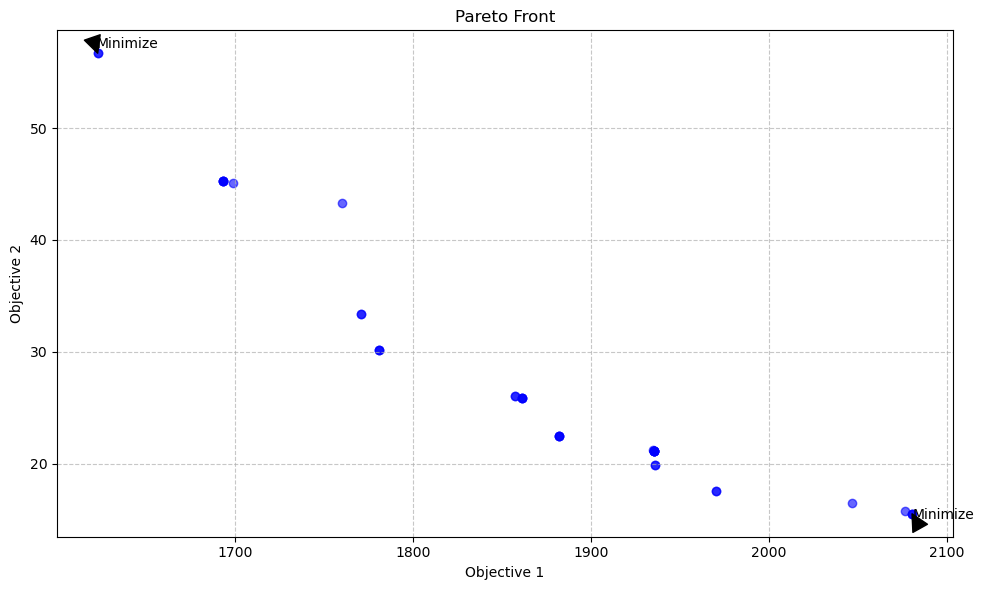

In [713]:
import matplotlib.pyplot as plt

pareto_front = [p for p in final_population if p.rank == 1]

# Assuming pareto_front is already defined
x = [solution.objectives[0] for solution in pareto_front]
y = [solution.objectives[1] for solution in pareto_front]

plt.figure(figsize=(10, 6))
plt.scatter(x, y, c='blue', alpha=0.6)
plt.title('Pareto Front')
plt.xlabel('Objective 1')
plt.ylabel('Objective 2')
plt.grid(True, linestyle='--', alpha=0.7)

plt.annotate('Minimize', xy=(min(x), max(y)), xytext=(min(x)-0.5, max(y)+0.5),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('Minimize', xy=(max(x), min(y)), xytext=(max(x)+0.5, min(y)-0.5),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.tight_layout()
plt.show()